In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# functions needed for pr_auc_score()
from sklearn.metrics import auc, precision_recall_curve
from sklearn import metrics

# functions needed for imbalanced_cross_validation_score()
from sklearn.model_selection import StratifiedKFold

# sampler objects
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, AllKNN, ClusterCentroids, EditedNearestNeighbours, InstanceHardnessThreshold
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn import under_sampling

# Classification models to compare
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn import svm
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, BalanceCascade, EasyEnsemble, EasyEnsembleClassifier, RUSBoostClassifier

from sklearn import preprocessing 

from sklearn.metrics import matthews_corrcoef

from sklearn.decomposition import PCA

from xgboost import XGBClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def pr_auc_score(clf, x, y):
    '''
        This function computes area under the precision-recall curve. 
    '''
      
    precisions, recalls,_ = precision_recall_curve(y, clf.predict_proba(x)[:,1], pos_label=1)
    
    return auc(recalls, precisions)

In [3]:
def Confusion_matrix(clf, x, y):
    cm = metrics.confusion_matrix(y, clf.predict(x))
    mcc = matthews_corrcoef(y, clf.predict(x))
    
    return (cm[0][0], cm[0][1], cm[1][0], cm[1][1], mcc)

In [4]:
def imbalanced_cross_validation_score(clf, x, y, cv, scoring, sampler):
    
    cv_score = 0.
    train_score = 0.
    test_score = 0.
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    MCC = 0
    
    # stratified k-fold creates folds with the same ratio of positive 
    # and negative samples as the entire dataset.
    
    skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=False)
    
    for train_idx, test_idx in skf.split(x,y):
        
        xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(x[train_idx],y[train_idx])
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        TN_train, FP_train, FN_train, TP_train, mcc_train = scoring(clf, xfold_train_sampled, yfold_train_sampled)
        TN_test, FP_test, FN_test, TP_test, mcc_test  = scoring(clf, x[test_idx], y[test_idx])
        # tn, fp, fn, tp
        print("Train TP: {0} Train FP: {1} Train FN: {2} Train TN: {3}; Test TP: {4} Test FP: {5} Test FN: {6} Test TN: {7}".format(TP_train, FP_train, FN_train, TN_train, TP_test, FP_test, FN_test, TN_test))
        print("MCC train: {0} and MCC test: {1}".format(mcc_train, mcc_test))
        
        TP += TP_test
        FP += FP_test
        FN += FN_test
        TN += TN_test
        MCC += mcc_test
        
        
        if(mcc_test > 0.7):
            cv_mean.append(mcc_test)
            cv_mean.append("|")
            cv_mean.append(test_idx)
        

    ave_tp = TP/cv
    ave_fp = FP/cv
    ave_fn = FN/cv
    ave_tn = TN/cv
    ave_mcc = MCC/cv
    
    sensitivity = ave_tp/(ave_tp + ave_fn)
    specificity = ave_tn/(ave_fp + ave_tn)
    
    g_mean = math.sqrt(sensitivity * specificity)
    # mcc = (ave_tp * ave_tn - ave_fp * ave_fn)/math.sqrt((ave_tp + ave_fp) * (ave_tp + ave_fn) * (ave_tn + ave_fp) * (ave_tn + ave_fn))
    
    
    
    values = [sensitivity, specificity, g_mean, ave_mcc]
    
        
    return values

In [98]:
x_train_o = pd.read_csv('financial_data.csv')
y_train_o = pd.read_csv('revealed_businesses.csv')

x_test_o = pd.read_csv("testing_data.csv")

x_train_o.replace('?', np.nan, inplace=True)
x_train_o = x_train_o.astype('float64')


x_test_o.replace('?', np.nan, inplace=True)
x_test_o = x_test_o.astype('float64')
x_test_v = x_test_o.drop(columns=['Var1'])


data_all = x_train_o.merge(y_train_o, on='Var1', how = 'left')

data_nolabel = data_all[data_all.Var66.isnull()]
data_label = data_all[data_all.Var66.notnull()]

data_nolabel_v = data_nolabel.drop(columns=['Var1', 'Var66'])
data_nolabel_id = data_nolabel['Var1']

data_label_v = data_label.drop(columns=['Var1', 'Var66'])
data_label_id = data_label['Var1']

data_all_v = data_all.drop(columns=['Var1', 'Var66'])
data_all_v_mean = data_all_v.mean()
data_all_v_f = data_all_v.fillna(data_all_v_mean)
minmax_scaler = preprocessing.MinMaxScaler().fit(data_all_v)

data_nolabel_v_f = data_nolabel_v.fillna(data_all_v_mean)
data_label_v_f = data_label_v.fillna(data_label_v.mean())
x_test_v_f = x_test_v.fillna(data_label_v.mean())

In [99]:
corr = data_label.drop(columns=['Var1']).fillna(data_label.drop(columns=['Var1']).mean()).corr()

In [100]:
corr[abs(corr.Var66)>0.03]['Var66']

Var3     0.068580
Var4    -0.056287
Var11   -0.068998
Var25   -0.049898
Var26   -0.054078
Var38    0.039216
Var39   -0.058141
Var52    0.064268
Var66    1.000000
Name: Var66, dtype: float64

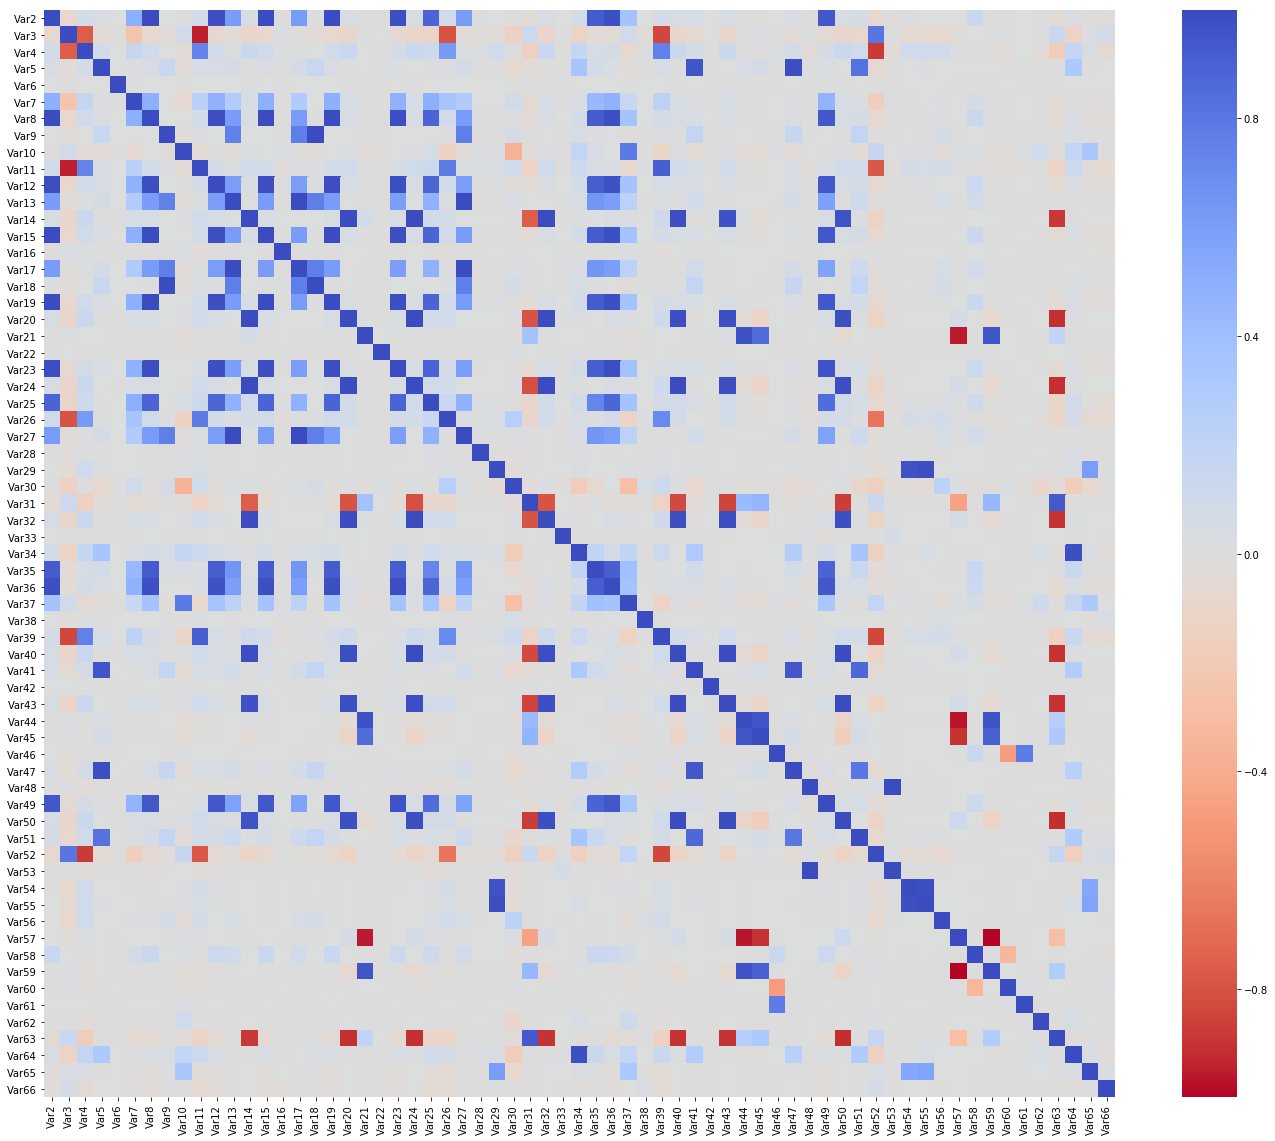

In [101]:
f, ax1 = plt.subplots(1, 1, figsize=(24,20))

sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)

In [102]:
features=['Var28', 'Var22', 'Var17', 'Var14', 'Var35', 'Var30', 'Var25', 'Var27',
       'Var20', 'Var65', 'Var16', 'Var60', 'Var38', 'Var10', 'Var40', 'Var7',
       'Var56', 'Var11', 'Var34', 'Var63', 'Var26', 'Var39', 'Var59', 'Var47',
       'Var46', 'Var61', 'Var45', 'Var15', 'Var57', 'Var54', 'Var18', 'Var31',
       'Var43', 'Var24', 'Var32', 'Var62', 'Var42', 'Var13', 'Var41', 'Var51',
       'Var44', 'Var6', 'Var33', 'Var58', 'Var37', 'Var36', 'Var64', 'Var52',
       'Var23', 'Var5', 'Var21', 'Var8', 'Var9', 'Var4', 'Var29', 'Var2',
       'Var12', 'Var3', 'Var19', 'Var48', 'Var55', 'Var50', 'Var53', 'Var49']

In [103]:
feature_selected=['Var28', 'Var22', 'Var17', 'Var14', 'Var35', 'Var30', 'Var25', 'Var27',
       'Var20', 'Var65', 'Var16', 'Var60', 'Var38', 'Var10', 'Var7',
       'Var56', 'Var11', 'Var34', 'Var26', 'Var39', 'Var59', 'Var47',
       'Var46', 'Var61', 'Var45', 'Var15', 'Var57', 'Var54', 'Var18',
       'Var43', 'Var24', 'Var32', 'Var62', 'Var42', 'Var13', 'Var41', 'Var51',
       'Var44', 'Var6', 'Var33', 'Var58', 'Var37', 'Var36', 'Var64', 'Var52',
       'Var23', 'Var5', 'Var8', 'Var9', 'Var4', 'Var29', 'Var2',
       'Var12', 'Var19', 'Var48', 'Var55', 'Var50', 'Var53', 'Var49']

In [104]:
#3, 40,21,63

In [105]:
data_label_v_f_s = data_label_v_f#[feature_selected]

In [91]:
X = data_label_v_f_s.values
y = data_label['Var66'].values

In [92]:
x = X#preprocessing.RobustScaler().fit_transform(X)

In [93]:
clfs={
#     'gnb': GaussianNB(),
#     'svm': svm.OneClassSVM(),
#     'lr':  LogisticRegression(),
#     'rfc': RandomForestClassifier(),
#     'et': ExtraTreesClassifier(),
#     'ada': AdaBoostClassifier(),
#     'ml': MLPClassifier(),
#     'bb': BalancedBaggingClassifier(base_estimator = XGBClassifier(max_depth=5, subsample=0.8, scale_pos_weight=0.5)), 
#                                           n_estimators = 15, bootstrap = True),
#   'fr_bb': BalancedRandomForestClassifier(random_state=42),
    'xgb': XGBClassifier(learning_rate=0.15,scale_pos_weight=0.5, max_depth=6, subsample=0.9, n_estimators=500, gamma=0, colsample_bytree=0.9)
    #'bc': BalanceCascade(),
#     'ee': EasyEnsemble(),
#     'eec': EasyEnsembleClassifier(),
#     'rbc': RUSBoostClassifier()
    #BalanceCascade, EasyEnsemble, EasyEnsembleClassifier, RUSBoostClassifier
    
}
cv = 5

cv_mean = []
for clf_name in clfs:
    print("Classifier: {0}".format(clf_name))
    # Logistic regression score with Random Over-sampling
    print("Random over-sampling")
    values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, RandomOverSampler(random_state=42))
    print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | mcc: %.2f"%(values[0], values[1], values[2], values[3]))

#     # Logistic regression score with SMOTEENN
#     print("SMOTEENN over-sampling")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, SMOTEENN())
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | mcc: %.2f"%(values[0], values[1], values[2], values[3]))

#     # Logistic regression score with SMOTETomek
#     print("SMOTETomek over-sampling")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, SMOTETomek())
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | mcc: %.2f"%(values[0], values[1], values[2], values[3]))

    
    
#     # Logistic regression score with SMOTE
#     print("SMOTE over-sampling")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, SMOTE())
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | mcc: %.2f"%(values[0], values[1], values[2], values[3]))

#     # Logistic regression score with ADASYN
#     print("ADASYN over-sampling")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, ADASYN())
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | mcc: %.2f"%(values[0], values[1], values[2], values[3]))

#     # Logistic regression score with Random Under Sampling
#     print("Random under-sampling")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, under_sampling.RandomUnderSampler())
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | mcc: %.2f"%(values[0], values[1], values[2], values[3]))
#, ClusterCentroids, EditedNearestNeighbours, InstanceHardnessThreshold
    print("-"*70)
    print()
    

Classifier: xgb
Random over-sampling
Train TP: 3767 Train FP: 0 Train FN: 0 Train TN: 3767; Test TP: 17 Test FP: 5 Test FN: 17 Test TN: 937
MCC train: 1.0 and MCC test: 0.611102972289776
Train TP: 3767 Train FP: 0 Train FN: 0 Train TN: 3767; Test TP: 19 Test FP: 4 Test FN: 15 Test TN: 938
MCC train: 1.0 and MCC test: 0.6703731129704765
Train TP: 3767 Train FP: 0 Train FN: 0 Train TN: 3767; Test TP: 19 Test FP: 2 Test FN: 15 Test TN: 940
MCC train: 1.0 and MCC test: 0.7035178160722226
Train TP: 3767 Train FP: 0 Train FN: 0 Train TN: 3767; Test TP: 18 Test FP: 1 Test FN: 16 Test TN: 941
MCC train: 1.0 and MCC test: 0.7012195430764337
Train TP: 3768 Train FP: 0 Train FN: 0 Train TN: 3768; Test TP: 20 Test FP: 0 Test FN: 14 Test TN: 941
MCC train: 1.0 and MCC test: 0.7613225003189112
sensitivity: 0.55 | specificity: 1.00 | g_mean: 0.74 | mcc: 0.69
----------------------------------------------------------------------



In [ ]:
21